In [1]:
import pandas as pd
import os

df = pd.read_csv('data/train.csv')

In [2]:
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

def impute_lot_frontage_regression(df):
    # 1. Select the features you identified
    features = ['LotFrontage', 'LotArea', 'MSSubClass', 'MSZoning', 'Street', 'LotShape']
    subset = df[features].copy()
    
    # 2. Convert categorical text to numbers (One-Hot Encoding)
    # This turns 'Street' into 'Street_Pave', 'Street_Grvl', etc.
    subset_encoded = pd.get_dummies(subset, columns=['MSZoning', 'Street', 'LotShape'], drop_first=True)
    
    # 3. Setup the Imputer using Linear Regression
    # max_iter=10 means it will refine the guess 10 times
    lr = LinearRegression()
    imp = IterativeImputer(estimator=lr, max_iter=10, random_state=42)
    
    # 4. Fit and Transform
    # The imputer learns the relationship between LotArea/Zoning and LotFrontage
    imputed_data = imp.fit_transform(subset_encoded)
    
    # 5. Bring the result back to the original dataframe
    # The first column in our subset_encoded was LotFrontage
    df['LotFrontage'] = imputed_data[:, 0]
    
    return df

In [3]:
df = impute_lot_frontage_regression(df)

In [4]:
df['LotFrontage'].isna().sum()

np.int64(0)

In [5]:
def fill_categorical_nulls(df, cols_to_fix, fill_value="Missing"):
    """
    Fills specific categorical columns with a custom string.
    """
    for col in cols_to_fix:
        # We use .astype(str) first to ensure no conflicts with 'Category' dtypes
        df[col] = df[col].fillna(fill_value)
    return df


col_to_fill = [
    "Alley",
    "BsmtCond",
    "BsmtQual",
    "BsmtExposure",
    "BsmtFinType1",
    "BsmtFinType2",
    "FireplaceQu",
    "GarageType",
    "GarageFinish",
    "GarageQual",
    "GarageCond",
    "PoolQC",
    "Fence",
    "MiscFeature",
]

df = fill_categorical_nulls(
    df,
    col_to_fill,
    fill_value="None",
)

print(df[col_to_fill].isna().sum())

Alley           0
BsmtCond        0
BsmtQual        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
FireplaceQu     0
GarageType      0
GarageFinish    0
GarageQual      0
GarageCond      0
PoolQC          0
Fence           0
MiscFeature     0
dtype: int64


In [6]:
def sync_masonry_data(df):
    # 1. Scenario: Both are Null
    # Logic: If we don't know the type AND the area is 0 or null, it's 'None'
    mask_both_null = df['MasVnrType'].isnull() & ((df['MasVnrArea'].isnull()) | (df['MasVnrArea'] == 0))
    df.loc[mask_both_null, 'MasVnrType'] = 'None'
    df.loc[mask_both_null, 'MasVnrArea'] = 0
    
    # 2. Scenario: Type is Null but Area > 0
    # Logic: There is masonry (area exists), but the type is unknown. Label as 'Other'
    mask_type_missing_only = df['MasVnrType'].isnull() & (df['MasVnrArea'] > 0)
    df.loc[mask_type_missing_only, 'MasVnrType'] = 'Other'
    
    # 3. Final Safety: If Area is still null but Type is known (like 'BrkFace')
    # Fill Area with the median area of that specific Type
    df['MasVnrArea'] = df.groupby('MasVnrType')['MasVnrArea'].transform(lambda x: x.fillna(x.median()))
    
    # Ensure any remaining 'None' types have exactly 0 area
    df.loc[df['MasVnrType'] == 'None', 'MasVnrArea'] = 0
    
    return df

df = sync_masonry_data(df)

In [7]:
# 1. First, ensure if Type is 'None', Area is 0
df.loc[df['MasVnrType'] == 'None', 'MasVnrArea'] = df.loc[df['MasVnrType'] == 'None', 'MasVnrArea'].fillna(0)

# 2. For houses that HAVE a type but are missing the Area, use the median of that specific type
# This ensures a 'Stone' house gets a 'Stone' sized area median
df['MasVnrArea'] = df.groupby('MasVnrType')['MasVnrArea'].transform(lambda x: x.fillna(x.median()))

# 3. Final safety check: if any remain (usually if Type was also Null), fill with 0
df['MasVnrArea'] = df['MasVnrArea'].fillna(0)

In [8]:
# Fill the single missing value with the most common electrical type
df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])

In [ ]:
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(df['GarageYrBlt'].median())

In [12]:
# Calculate nulls per column
null_counts = df.isnull().sum()

# Display only columns that have at least one null, sorted highest to lowest
print(null_counts[null_counts > 0].sort_values(ascending=False))

Series([], dtype: int64)


In [29]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PowerTransformer

def prep_data_numeric_cols(df, numeric_feats, threshold=0.75):
    """
    Automatically detects and fixes skewness in numerical columns.
    - Positive skew > threshold: Applied log1p
    - Negative skew < -threshold: Applied Yeo-Johnson PowerTransform
    """
    df_transformed = df.copy()
    
    # 2. Calculate skewness for all columns
    skewness = df_transformed[numeric_feats].skew()
    
    # 3. Filter columns that exceed the threshold
    skewed_cols = skewness[abs(skewness) > threshold].index
    
    print(f"Detected {len(skewed_cols)} skewed columns to fix.\n")

    for col in skewed_cols:
        current_skew = skewness[col]
        
        # Scenario A: Too High (Positive Skew) -> Log Transform
        if current_skew > threshold:
            df_transformed[col] = np.log1p(df_transformed[col])
            print(f"FIXED [{col}]: Positive Skew ({current_skew:.2f}) -> Applied Log1p")
            
        # Scenario B: Too Low (Negative Skew) -> Power Transform
        elif current_skew < -threshold:
            # PowerTransformer expects a 2D array, so we reshape
            pt = PowerTransformer(method='yeo-johnson')
            df_transformed[col] = pt.fit_transform(df_transformed[[col]])
            print(f"FIXED [{col}]: Negative Skew ({current_skew:.2f}) -> Applied Yeo-Johnson")
            
    return df_transformed

In [38]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, PowerTransformer

def prep_label_data(y, threshold=0.75):
    """
    Input: y (Series or 1D array)
    Returns: y_transformed (array), info (dict)
    """
    # Ensure y is a DataFrame for sklearn compatibility
    y_df = pd.DataFrame(y)
    target_name = y_df.columns[0]
    
    info = {
        'transform_type': None,
        'scaler': StandardScaler(),
        'pt': None
    }
    
    skew = y_df[target_name].skew()
    
    # 1. Handle Skewness (Transformation)
    if skew > threshold:
        y_df[target_name] = np.log1p(y_df[target_name])
        info['transform_type'] = 'log1p'
    elif skew < -threshold:
        info['pt'] = PowerTransformer(method='yeo-johnson')
        y_df[target_name] = info['pt'].fit_transform(y_df[[target_name]])
        info['transform_type'] = 'yeo-johnson'
    
    # 2. Apply Scaling
    y_scaled = info['scaler'].fit_transform(y_df)
    
    return y_scaled.flatten(), info

# Usage:
# y_train_scaled, y_info = prep_label_data(df_train, 'SalePrice')

In [33]:
X = df.drop(columns=["SalePrice"])
y = df["SalePrice"]

In [34]:
import pandas as pd

numeric_cols = [
    "LotFrontage",
    "LotArea",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "TotalBsmtSF",
    "1stFlrSF",
    "2ndFlrSF",
    "GrLivArea",
    "GarageArea",
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "3SsnPorch",
    "ScreenPorch",
    "PoolArea"
]

cat_cols = [col for col in X.columns if col not in numeric_cols]

In [42]:
print(cat_cols)

['Id', 'MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']


In [47]:
from sklearn.preprocessing import StandardScaler

# Step 1: Fix Skewness on Numeric Columns
# (Using the fix_skewness function we wrote in the previous step)
X_fixed = prep_data_numeric_cols(X, numeric_cols, threshold=0.75)
scaler = StandardScaler()
X_fixed[numeric_cols] = scaler.fit_transform(X_fixed[numeric_cols])
X_fixed = X_fixed.drop(columns=cat_cols)

# Step 2: One-Hot Encode Categorical Columns
# drop_first=True prevents multicollinearity (the 'Dummy Variable Trap')
X_encoded = pd.get_dummies(X[cat_cols], drop_first=True)

# Step 3: Combine them back together
X_final = pd.concat([X_fixed, X_encoded], axis=1)

Detected 15 skewed columns to fix.

FIXED [LotFrontage]: Positive Skew (2.20) -> Applied Log1p
FIXED [LotArea]: Positive Skew (12.21) -> Applied Log1p
FIXED [BsmtFinSF1]: Positive Skew (1.69) -> Applied Log1p
FIXED [BsmtFinSF2]: Positive Skew (4.26) -> Applied Log1p
FIXED [BsmtUnfSF]: Positive Skew (0.92) -> Applied Log1p
FIXED [TotalBsmtSF]: Positive Skew (1.52) -> Applied Log1p
FIXED [1stFlrSF]: Positive Skew (1.38) -> Applied Log1p
FIXED [2ndFlrSF]: Positive Skew (0.81) -> Applied Log1p
FIXED [GrLivArea]: Positive Skew (1.37) -> Applied Log1p
FIXED [WoodDeckSF]: Positive Skew (1.54) -> Applied Log1p
FIXED [OpenPorchSF]: Positive Skew (2.36) -> Applied Log1p
FIXED [EnclosedPorch]: Positive Skew (3.09) -> Applied Log1p
FIXED [3SsnPorch]: Positive Skew (10.30) -> Applied Log1p
FIXED [ScreenPorch]: Positive Skew (4.12) -> Applied Log1p
FIXED [PoolArea]: Positive Skew (14.83) -> Applied Log1p


In [48]:
X_final

,LotFrontage,LotArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageArea,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-0.113038,-0.133270,0.779431,-0.355342,-0.340511,0.002513,-0.803645,1.180528,0.529194,0.351000,...,False,False,False,False,True,False,False,False,True,False
1,0.510670,0.113413,0.888257,-0.355342,0.002218,0.341114,0.418479,-0.870117,-0.381965,-0.060731,...,False,False,False,False,True,False,False,False,True,False
2,0.022341,0.420049,0.654803,-0.355342,0.230372,0.065397,-0.576677,1.184762,0.659631,0.631726,...,False,False,False,False,True,False,False,False,True,False
3,-0.352968,0.103317,0.384539,-0.355342,0.348034,-0.105819,-0.439421,1.143550,0.541448,0.790804,...,False,False,False,False,True,False,False,False,False,False
4,0.657471,0.878431,0.754400,-0.355342,0.295711,0.256237,0.112127,1.244087,1.282295,1.698485,...,False,False,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,-0.254717,-0.259231,-1.414140,-0.355342,0.654093,0.096134,-0.465737,1.117594,0.416598,-0.060731,...,False,False,False,False,True,False,False,False,True,False
1456,0.693091,0.725429,0.816966,2.409693,0.394815,0.515947,1.981524,-0.870117,1.106648,0.126420,...,False,False,False,False,True,False,False,False,True,False
1457,-0.067240,-0.002359,0.464947,-0.355342,0.609301,0.261554,0.228208,1.271356,1.470102,-1.033914,...,False,False,False,False,True,False,False,False,True,False
1458,0.022341,0.136833,-0.106220,3.405917,-3.047600,0.203637,-0.077721,-0.870117,-0.854536,-1.090059,...,False,False,False,False,True,False,False,False,True,False


In [49]:
y_scaled, y_info = prep_label_data(y)

In [52]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_final, y_scaled, test_size=0.2, random_state=42)

In [63]:
def revert_label_data(y_pred_scaled, info):
    """
    Reverts scale first, then reverts the skewness transformation.
    """
    # Reshape for sklearn
    y_reverted = y_pred_scaled.reshape(-1, 1)
    
    # 1. Reverse Scaling (Z-score -> Raw Values)
    y_reverted = info['scaler'].inverse_transform(y_reverted)
    
    # 2. Reverse Skewness Fix
    if info['transform_type'] == 'log1p':
        y_reverted = np.expm1(y_reverted)
    elif info['transform_type'] == 'yeo-johnson':
        y_reverted = info['pt'].inverse_transform(y_reverted)
        
    return y_reverted.flatten()

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def train(model, X_train, y_train, X_val, y_val):
    model_name = type(model).__name__
    
    if "XGB" in model_name:
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    else:
        model.fit(X_train, y_train)

    y_val_preds_scaled = model.predict(X_val)

    y_val_final = revert_label_data(y_val_preds_scaled, y_info)

    # 2. Revert the actual y_val values to original scale for a fair comparison
    y_val_actual = revert_label_data(y_val, y_info)

    # 3. Calculate Performance Metrics
    r2 = r2_score(y_val_actual, y_val_final)
    rmse = np.sqrt(mean_squared_error(y_val_actual, y_val_final))
    mae = mean_absolute_error(y_val_actual, y_val_final)

    # Relative Absolute Error (RAE)
    rae = np.sum(np.abs(y_val_actual - y_val_final)) / np.sum(
        np.abs(y_val_actual - y_val_actual.mean())
    )

    print(f"--- {model_name} Performance ---")
    print(f"R² Score: {r2:.4f}")
    print(f"RMSE:     ${rmse:,.2f}")
    print(f"MAE:      ${mae:,.2f}")
    print(f"RAE:      {rae:.4f}\n")
    
    return model

In [67]:
import xgboost as xgb
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor

en_model = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)

xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    random_state=42
)

rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=10,
    min_samples_split=5,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42
)

en_model = train(en_model, X_train, y_train, X_val, y_val)
rf_model = train(rf_model, X_train, y_train, X_val, y_val)  
xgb_model = train(xgb_model, X_train, y_train, X_val, y_val)


--- ElasticNet Performance ---
R² Score: 0.8449
RMSE:     $34,491.66
MAE:      $19,612.60
RAE:      0.3168

--- RandomForestRegressor Performance ---
R² Score: 0.8246
RMSE:     $36,675.15
MAE:      $19,417.62
RAE:      0.3137

--- XGBRegressor Performance ---
R² Score: 0.9164
RMSE:     $25,320.69
MAE:      $15,471.99
RAE:      0.2499



In [ ]:
# # 1. Create a summary DataFrame
# results = pd.DataFrame({
#     'Actual': y_val_actual,
#     'Predicted': y_val_final,
#     'Error': y_val_actual - y_val_final,
#     'Abs_Error': np.abs(y_val_actual - y_val_final)
# }, index=X_val.index)

# # 2. Get the 5 largest errors
# top_misses = results.sort_values(by='Abs_Error', ascending=False).head(10)

# print("Top houses where the model struggled:")
# print(top_misses)

Top houses where the model struggled:
        Actual      Predicted          Error      Abs_Error
691   755000.0  569367.500000  185632.500000  185632.500000
898   611657.0  475132.468750  136524.531250  136524.531250
774   395000.0  288142.437500  106857.562500  106857.562500
581   253293.0  347626.000000  -94333.000000   94333.000000
261   276000.0  360691.531250  -84691.531250   84691.531250
1046  556581.0  473385.750000   83195.250000   83195.250000
218   311500.0  234856.125000   76643.875000   76643.875000
451   280000.0  207070.609375   72929.390625   72929.390625
350   318061.0  258855.796875   59205.203125   59205.203125
1243  465000.0  407497.406250   57502.593750   57502.593750


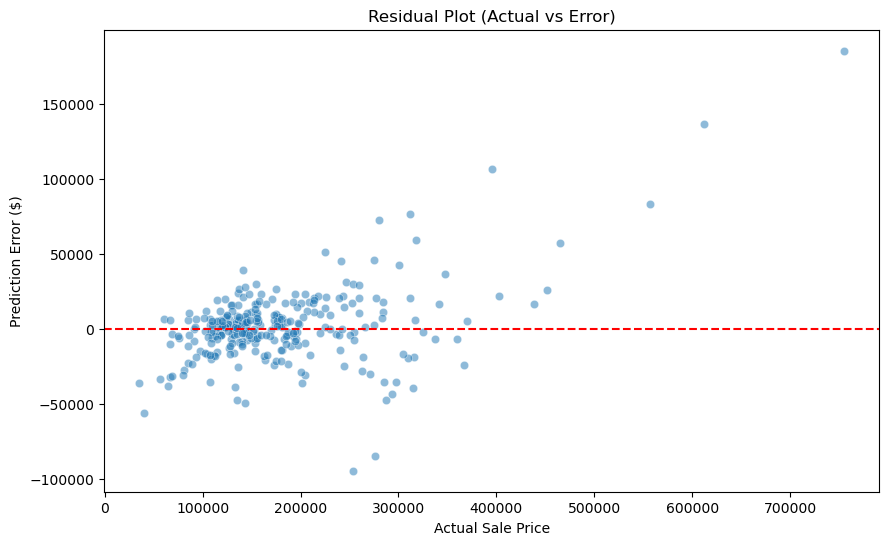

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x=results['Actual'], y=results['Error'], alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot (Actual vs Error)')
plt.xlabel('Actual Sale Price')
plt.ylabel('Prediction Error ($)')
plt.show()